# 构建类别条件（Class-Conditioned Diffusion Model）扩散模型

在本示例笔记本中，我们将演示如何为扩散模型添加条件信息。具体而言，我们将在 MNIST 数据集上训练一个**类别条件**扩散模型，，从而在推理阶段能够指定要生成的数字类别。

正如本单元开篇所述，这只是为扩散模型注入附加条件信息的众多方式之一；之所以选择这种方案，是因为它实现相对简单。


In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

d:\Users\yin-pu\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:08<00:00, 1113745.72it/s]


Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 98533.17it/s]


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:07<00:00, 223843.84it/s]


Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 17545.80it/s]

Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 7, 2, 4, 7, 2, 9, 2])


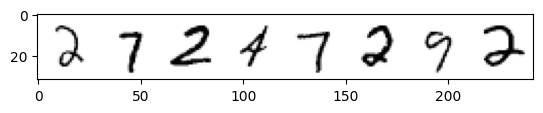

In [2]:
# 加载 MNIST 训练集，数据会被下载到 mnist/ 目录下，并转换为 Tensor
dataset = torchvision.datasets.MNIST(
    root="mnist/", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

# 将数据集传入 DataLoader，设置 batch 大小为 8，并打乱顺序
train_dataloader = DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True
)

# 从 DataLoader 中获取一个 batch 的数据
x, y = next(iter(train_dataloader))

# 打印输入张量的形状（batch_size, 通道数, 高, 宽）
print('Input shape:', x.shape)

# 打印对应的标签
print('Labels:', y)

# 可视化该 batch 的图像，并以灰度图显示
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
plt.show()

## 构建类别条件 UNet

我们将按以下流程注入类别条件信息：

- **创建标准 `UNet2DModel` 并新增输入通道**  
- **通过 Embedding 将类别标签映射为 shape 为 `(class_emb_size)` 的可学习向量**  
- **在通道维度拼接条件向量**：  
  ```python
  net_input = torch.cat((x, class_cond), 1)
  ```
- 将 net_input（总通道数为 class_emb_size + 1）送入 UNet，得到最终预测

在本示例中，class_emb_size 取 4——这是任意选择，你可以尝试：

- 设为 1：看看模型是否仍能有效工作

- 设为 10：与类别数相同

- 不用 nn.Embedding，直接使用类别标签的 one-hot 编码

In [3]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # 嵌入层：将类别标签映射为长度为 class_emb_size 的向量
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # 无条件 UNet 模型，但输入通道数增加了 class_emb_size，以接收类别条件信息
    self.model = UNet2DModel(
        sample_size=28,               # 目标图像分辨率
        in_channels=1 + class_emb_size, # 额外的输入通道，用于类别条件
        out_channels=1,               # 输出通道数
        layers_per_block=2,           # 每个 UNet 块中使用多少个 ResNet 层
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # 普通的 ResNet 下采样块
            "AttnDownBlock2D",    # 带空间自注意力的 ResNet 下采样块
            "AttnDownBlock2D", 
        ),
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # 带空间自注意力的 ResNet 上采样块
            "UpBlock2D",          # 普通的 ResNet 上采样块
        ),
    )

  # 前向传播：接受图像 x、时间步 t 以及类别标签 class_labels
  def forward(self, x, t, class_labels):
    # x 的形状：batch_size, 通道数, 宽, 高
    bs, ch, w, h = x.shape
    
    # 将类别标签映射到嵌入向量，然后调整形状以便拼接
    class_cond = self.class_emb(class_labels)                    # (bs, class_emb_size)
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1)  # (bs, class_emb_size, 1, 1)
    class_cond = class_cond.expand(bs, class_cond.shape[1], w, h) # (bs, class_emb_size, 28, 28)

    # 将原始图像和类别条件在通道维度上拼接
    net_input = torch.cat((x, class_cond), dim=1)  # (bs, 1+class_emb_size, 28, 28)

    # 将拼接后的输入与时间步一同送入 UNet，并返回生成的图像
    return self.model(net_input, t).sample        # (bs, 1, 28, 28)


如果你在维度或张量变换上感到困惑，可随时插入 `print` 语句来输出相关张量的形状，并检查它们是否符合你的预期。我也在部分中间变量后标注了形状信息，希望能帮助你更直观地理解整个流程。


## 训练与采样

在 **训练阶段**，我们不再像以前那样简单调用

```python
prediction = unet(x, t)
```

而是要把正确的标签 y 作为第三个参数传入：
```python
prediction = unet(x, t, y)
```

在 推断阶段，你可以传入任意想要的标签；如果模型训练得当，它应该生成与该标签匹配的图像。此处的 y 是 MNIST 的数字标签，取值范围为 0–9。

训练循环与Unit 1 示例基本相同。不同之处在于，我们现在预测 **噪声**（而非 Unit 1 中的去噪图像），以符合默认 `DDPMScheduler` 的目标函数；该调度器在训练阶段负责加噪，在推断阶段用于逐步生成样本。

训练过程可能需要较长时间。


  0%|          | 0/469 [00:00<?, ?it/s]d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\models\attention_processor.py:3317: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


Finished epoch 0. Average of the last 100 loss values: 0.051836


100%|██████████| 469/469 [00:41<00:00, 11.34it/s]


Finished epoch 1. Average of the last 100 loss values: 0.046035


100%|██████████| 469/469 [00:29<00:00, 15.96it/s]


Finished epoch 2. Average of the last 100 loss values: 0.044161


100%|██████████| 469/469 [00:29<00:00, 15.98it/s]


Finished epoch 3. Average of the last 100 loss values: 0.042346


100%|██████████| 469/469 [00:29<00:00, 15.83it/s]


Finished epoch 4. Average of the last 100 loss values: 0.041307


100%|██████████| 469/469 [00:29<00:00, 15.95it/s]


Finished epoch 5. Average of the last 100 loss values: 0.040305


100%|██████████| 469/469 [00:29<00:00, 15.79it/s]


Finished epoch 6. Average of the last 100 loss values: 0.040730


100%|██████████| 469/469 [00:29<00:00, 15.94it/s]


Finished epoch 7. Average of the last 100 loss values: 0.039238


100%|██████████| 469/469 [00:44<00:00, 10.50it/s]


Finished epoch 8. Average of the last 100 loss values: 0.039026


100%|██████████| 469/469 [00:51<00:00,  9.02it/s]

Finished epoch 9. Average of the last 100 loss values: 0.038815


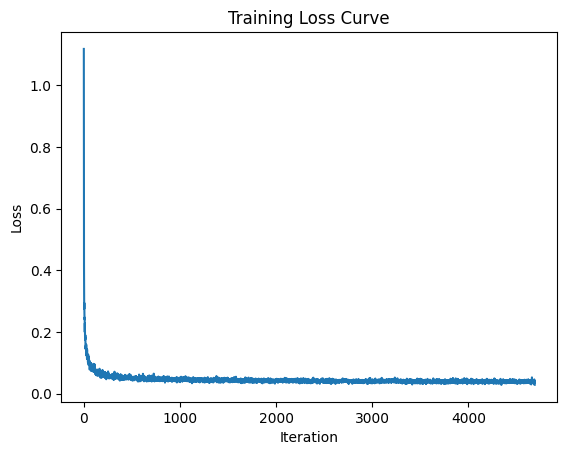

In [5]:
# 创建DDPMScheduler：使用 1000 个训练时间步和 squaredcos_cap_v2
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# 重新定义 DataLoader，将 batch 大小设置为 128，并打乱数据顺序
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# 训练轮数
n_epochs = 10

# 实例化并将网络移动到指定设备（如 GPU）
net = ClassConditionedUnet().to(device)

# 损失函数：均方误差损失
loss_fn = nn.MSELoss()

# 优化器：Adam，学习率 1e-3
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# 用于记录训练过程中的损失值
losses = []

# 训练循环
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        # 将输入 x 映射到 (-1, 1) 并移动到设备；标签 y 也移动到设备
        x = x.to(device) * 2 - 1  
        y = y.to(device)
        
        # 生成与 x 同形状的高斯噪声
        noise = torch.randn_like(x)
        
        # 随机采样时间步（0 到 999）
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        
        # 向 x 添加噪声，得到 noisy_x
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # 将带噪声的输入和时间步及标签传入网络，获得预测的噪声
        pred = net(noisy_x, timesteps, y)

        # 计算模型预测的噪声与真实噪声之间的 MSE 损失
        loss = loss_fn(pred, noise)

        # 反向传播并更新模型参数
        opt.zero_grad()
        loss.backward()
        opt.step()

        # 将当前损失值记录下来
        losses.append(loss.item())

    # 每个 epoch 结束后，打印最近 100 次迭代的平均损失
    avg_loss = sum(losses[-100:]) / 100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# 绘制损失曲线
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


当训练结束后，我们可以输入不同的标签作为条件来采样图像：

1000it [00:13, 75.87it/s]


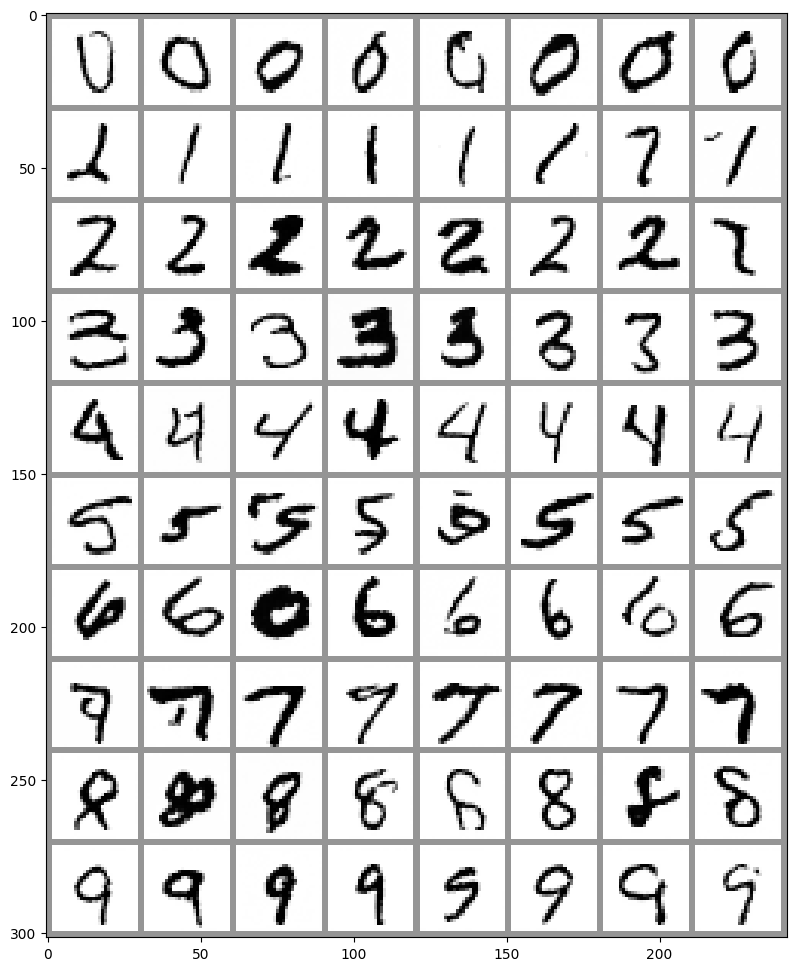

In [9]:
# 采样一些不同的数字：

# 准备随机噪声 x 作为起始，以及我们想要的标签 y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# 采样循环
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # 获取模型预测噪声
    with torch.no_grad():
        residual = net(x, t, y)  # 注意这里也要传入我们的标签 y

    # 根据噪声和当前时刻更新样本
    x = noise_scheduler.step(residual, t, x).prev_sample

# 显示结果
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(
    torchvision.utils.make_grid(
        x.detach().cpu().clip(-1, 1),
        nrow=8
    )[0],
    cmap='Greys'
)
plt.show()
